###  Created by Luis A. Sanchez-Perez (alejand@umich.edu)

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as alg
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output
import keyboard
from sklearn.metrics import r2_score
from enum import Enum

In [2]:
# Computes the numerical gradient using the central difference for interior data points.
def gradient(f,spacing):
    nx = f.shape[0]
    ny = f.shape[1]
    dx = np.zeros((nx,ny))
    dy = np.zeros((nx,ny))
    
    if nx < 2 or ny < 2:
        return dx,dy

    for i in range(1,nx-1):
        dy[i,:] = (f[i+1,:] - f[i-1,:])/(2*spacing)
    dy[0,:] = (f[1,:] - f[0,:])/(2*spacing)
    dy[nx-1,:] = (f[nx-1,:] - f[nx-2,:])/(2*spacing)
    
    for j in range(1,ny-1):
        dx[:,j] = (f[:,j+1] - f[:,j-1])/(2*spacing)
    dx[:,0] = (f[:,1] - f[:,0])/(2*spacing)
    dx[:,ny-1] = (f[:,ny-1] - f[:,ny-2])/(2*spacing)
    
    return dx,dy

In [3]:
def compute_metrics(W,X,y,niter):
    h = X.dot(W[:,niter])
    print('After {:} iterations, R2 Score: {}'.format(niter,'%.2f' % r2_score(y, h)))
    
def plot_fit(ax,w,x,y):
    ax.scatter(x,y,c='b')
    ax.plot(np.array([x.min(),x.max()]),np.array([[1,x.min()],[1,x.max()]]).dot(w),'k')
    ax.set_title('Linear fit')
    ax.set_xlabel('predictor')
    ax.set_ylabel('response')
    ax.set_xlim([0,8])
    ax.set_ylim([0,4])
    ax.grid()
    
def plot_contour(ax,W,niter):
    ax.contour(w0,w1,mesh_cost,levels=25)
    gstep = 3
    ax.quiver(w0[::gstep,::gstep],w1[::gstep,::gstep],-dw0[::gstep,::gstep],-dw1[::gstep,::gstep],width=0.003)
    ax.plot(W[0,:niter].T,W[1,:niter].T,'-rx') 
    ax.set_title('Cost function')
    ax.grid()
    
def plot_cost(ax,J,niter):
    ax.plot(np.arange(1,niter+1), J[:niter], 'k.-')
    ax.set_title('Cost function')
    ax.set_xlabel('iteration')
    ax.grid() 

def plot_surface(ax,W,J,niter):
    ax.plot_surface(w0,w1,mesh_cost,cmap='viridis',alpha=0.8)
    ax.plot(W[0,:niter].T,W[1,:niter].T,J[:niter],'-r*')
    ax_surf.view_init(30,(2*niter - 45)%360)
    ax.set_title('Cost function')
    ax.set_xlabel('intercept (w0)')
    ax.set_ylabel('slope (w1)')
    
class GradType(Enum):
    BATCH_GRAD = 0
    ADAGRAD = 1
    LINE_SEARCH = 2
    NEWTON_METHOD = 3

In [4]:
dataset = pd.read_csv('../../datasets/others/tremors/tremors.csv')
dataset = dataset.dropna()
dataset.head()

,amplitude,pct100-90,pct90-70,pct70-50,unconstrained,constrained,freq,fuzzy score,expert score,limb
0,0.6931,1.2570,4.7486,21.5084,0.8542,0.5706,5.5047,0.776057,1,RUE
1,0.1140,4.7393,3.7915,9.4787,0.0385,0.1895,6.3016,0.146397,0,LUE
2,0.0000,0.0000,0.0000,0.0000,0.0003,0.0049,6.6038,0.000501,0,RLE
3,0.0000,0.0000,0.0000,0.0000,0.0007,0.0059,6.9767,0.000501,0,LLE
4,0.0678,1.1076,5.0633,10.7595,0.5125,0.5402,6.1854,0.092817,0,RUE


In [5]:
# Init data
X = dataset.iloc[:,[0]].values
y = dataset['fuzzy score'].values
m,d = X.shape
X = np.hstack((np.ones((m,1)),X))

In [6]:
# Params
MAX_ITER = 1000
MIN_DELTA = 1e-5
batch_size = None
grad_method = GradType.ADAGRAD
cum_grad = np.zeros((d+1,))
epsilon = 1e-10

In [7]:
# Init algorithm
niter = 0
delta_J = MIN_DELTA
start = [2,-5]
W = np.array([start] * MAX_ITER,order='C',dtype='float64').T
residual = X.dot(W[:,niter]) - y
J = np.array([0.5*((residual.T).dot(residual))]*MAX_ITER)

In [8]:
# Mesh building
pts = 50
w0 = np.linspace(-5,5,pts)
w1 = np.linspace(-5,5,pts)
spacing = (w0.max() - w0.min())/pts
w0,w1 = np.meshgrid(w0,w1)
mesh = np.vstack((w0.flatten(), w1.flatten()))
mesh_cost = 0.5*((X.dot(mesh) - y.reshape(len(y),1))**2).sum(axis=0).reshape(pts,pts)
dw0,dw1 = gradient(mesh_cost,spacing)

After 22 iterations, R2 Score: 0.94


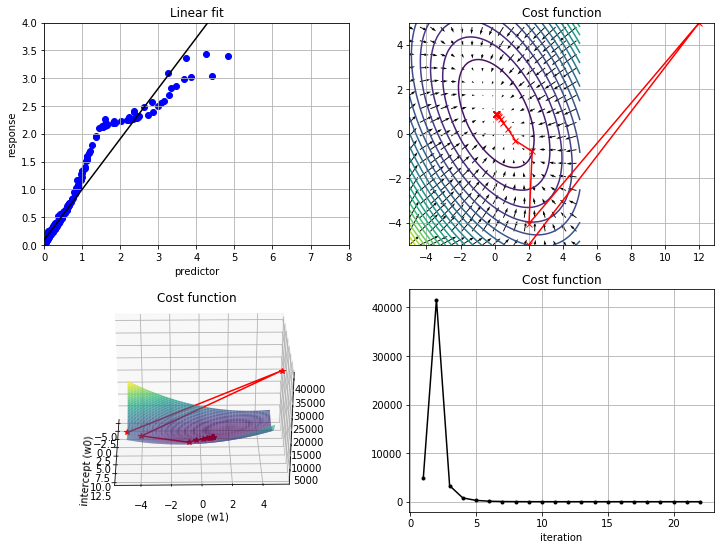

In [9]:
# Solve for w and plots progress
plot_progress = True
fig = plt.figure(figsize=(12,9))
ax_fit = fig.add_subplot(221)
ax_contour = fig.add_subplot(222)
ax_surf = fig.add_subplot(223,projection='3d')
ax_cost = fig.add_subplot(224)

while niter < MAX_ITER - 1 and abs(delta_J) >= MIN_DELTA:
    # plot graphical progress
    if plot_progress == True:
        # clear axes
        ax_fit.cla()
        ax_contour.cla()
        ax_surf.cla()
        ax_cost.cla()
        # plot progress
        plot_fit(ax_fit,W[:,niter],X[:,1],y)
        plot_contour(ax_contour,W,niter)
        plot_cost(ax_cost,J,niter) 
        plot_surface(ax_surf,W,J,niter)
        # clears output after some time
        display(fig)
        clear_output(wait = True)
        plt.pause(0.1)
        if keyboard.is_pressed('Esc'):
            plot_progress = False
            
    # Determines gradient
    # batch
    if batch_size == None:
        residual = X.dot(W[:,niter]) - y
        grad = (X.T).dot(residual)
    # stochastic
    else:
        indexes = rnd.permutation(m)[:batch_size]
        residual = X[indexes,:].dot(W[:,niter]) - y[indexes]
        grad = (X[indexes,:].T).dot(residual)

    # Determines update rule (step) according to chosen method
    if grad_method == GradType.BATCH_GRAD:
        alpha = 1e-3
        step = alpha * grad
    elif grad_method == GradType.ADAGRAD:
        alpha = 10
        cum_grad += (grad**2)
        step = (alpha / np.sqrt((epsilon + cum_grad))) * grad
    elif grad_method == GradType.LINE_SEARCH:
        H = (X.T).dot(X)         # you can move this outside the loop (only linear regression)
        alpha = (grad.T).dot(grad) / (grad.T).dot(H).dot(grad)
        step = alpha * grad
    elif grad_method == GradType.NEWTON_METHOD:
        H = (X.T).dot(X)          # you can move this outside the loop (only linear regression)
        step = alg.solve(H,grad)  #step = alg.pinv(H).dot(grad)

    # Move iteration pointer
    niter = niter + 1
    
    # Update weights and computes new cost
    W[:,niter] = W[:,niter - 1] - step
    residual = X.dot(W[:,niter]) - y
    J[niter] = 0.5*((residual.T).dot(residual))
    delta_J = J[niter - 1] - J[niter]
    
# Display training performance
compute_metrics(W,X,y,niter)
ax_fit.cla()
ax_contour.cla()
ax_surf.cla()
ax_cost.cla()
plot_fit(ax_fit,W[:,niter],X[:,1],y)
plot_contour(ax_contour,W,niter)
plot_cost(ax_cost,J,niter)
plot_surface(ax_surf,W,J,niter)
display(fig)

#### Notice
With Adagrad you can use more aggressive learning rates and still avoid diverging (something impossible to avoid in batch gradient descend for high learning rates). See the graphs above. Try changing the learning method from any of the available:
   * BATCH_GRAD = 0
   * ADAGRAD = 1
   * LINE_SEARCH = 2
   * NEWTON_METHOD = 3